# Model combining, Engsemble methods
- 종류:
    - 취합(aggregation): 사용할 개별 모형 집합 이미 결정
        - 다수결(major voting)
        - 배깅(bagging)
        - 랜덤 포레스트(Random Forests)
    - 부스팅(boosting): 사용할 모형을 계속 검색해나감
        - 에이다 부스트(Ada Boost)
        - 그레디언트 부스트(Gradient Boost)
- 효과:
    - 과최적 방지(decrease variance)
    - 단일 성능 안좋은 모형들을 모아 향상시킴
-

---

# 1. 취합
- p: 정답 출력 확률
- N: 모형 갯수
- 다수결 모형의 정답 출력 확률
$$
\sum_{k > \frac{N}{2}}^N \binom N k p^k (1-p)^{N-k}
$$

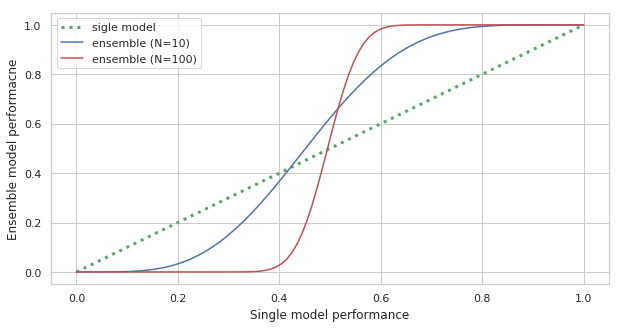

In [199]:
def total_error(p, N):
    te = 0.0
    for k in range(int(np.ceil(N/2)), N+1):
        te += sp.misc.comb(N, k) * p**k * (1-p)**(N-k)
    return te

x = np.linspace(0, 1, 100)
plt.figure(figsize=(10,5))
plt.plot(x, x, 'g:', lw=3, label='sigle model')
plt.plot(x, total_error(x, 10), 'b-', label='ensemble (N=10)')
plt.plot(x, total_error(x, 100), 'r-', label='ensemble (N=100)')
plt.legend()
plt.xlabel('Single model performance')
plt.ylabel('Ensemble model performacne')
plt.show()

## 1.1 취합 - 다수결 방법(major voting)
- `from sklearn.ensemble import VotingClassifier`
    - `estmators`: 개별모형 목록(리스트, named param 형식)
    - `voting`: hard / soft
    - `weight`: 리스트 형식

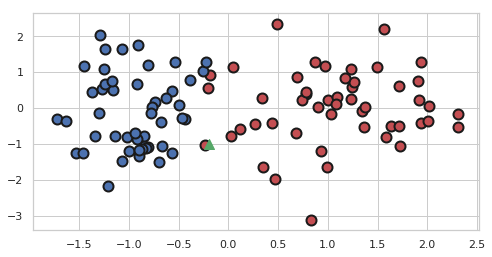

In [185]:
from sklearn.datasets import make_classification
X, y = make_classification(n_features=2, n_informative=1,
                          n_redundant=0, n_clusters_per_class=1,
                          random_state=97)
X_test = [-0.2, -1]
plt.figure(figsize=(8,4))
plt.scatter(X[y==1, 0], X[y==1, 1], marker='o', c='r', s=100, edgecolors='k', linewidths=2)
plt.scatter(X[y==0, 0], X[y==0, 1], marker='o', c='b', s=100, edgecolors='k', linewidths=2)
plt.scatter(X_test[0], X_test[1], marker='^', s=100, c='g',)
plt.show()

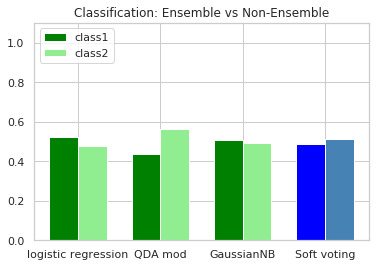

In [186]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import VotingClassifier

mod1 = LogisticRegression(random_state=88)
mod2 = QuadraticDiscriminantAnalysis()
mod3 = GaussianNB()
ensemble = VotingClassifier(estimators=[('lr', mod1), ('qda', mod2), ('gnb', mod3)], voting='soft')


probas = [c.fit(X, y).predict_proba([X_test]) for c in (mod1, mod2, mod3, ensemble)]
# mods' proba for easch class
class1_1 = [pr[0,0] for pr in probas]
class2_1 = [pr[0,1] for pr in probas]

# bar graph
ind = np.arange(4)
width = 0.35
# bar for class1
p1 = plt.bar(ind, np.hstack(([class1_1[:-1], [0]])), width, color='green')
p2 = plt.bar(ind + width, np.hstack(([class2_1[:-1], [0]])), width, color='lightgreen')
# bar for class2
p3 = plt.bar(ind, [0, 0, 0, class1_1[-1]], width, color='blue')
p4 = plt.bar(ind + width, [0, 0, 0, class2_1[-1]], width, color='steelblue')

plt.xticks(ind + 0.5 * width, ['logistic regression', 'QDA mod', 'GaussianNB', 'Soft voting'])
plt.ylim([0, 1.1])
plt.title('Classification: Ensemble vs Non-Ensemble')
plt.legend([p1[0], p2[0]], ['class1', 'class2'], loc='upper left')
plt.show()

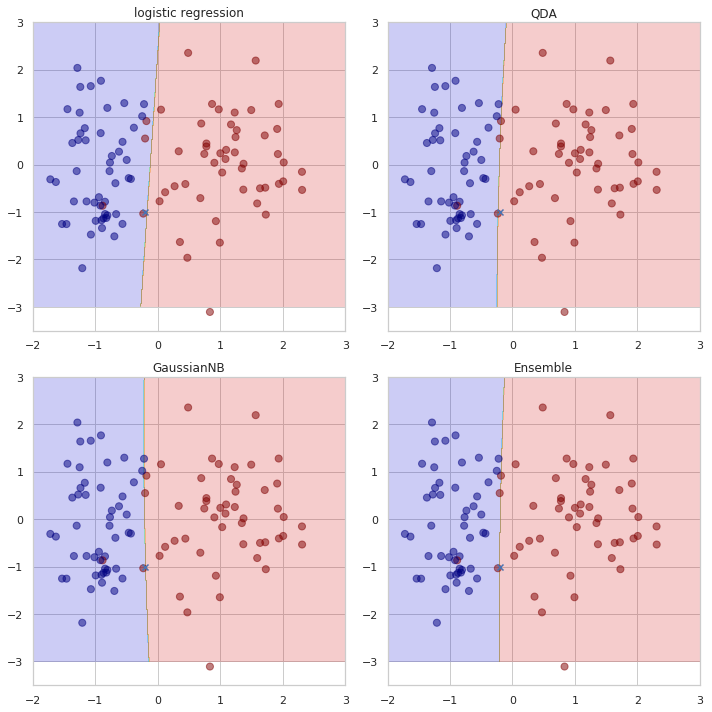

In [187]:
from itertools import product

x_min, x_max = -2, 3
y_min, y_max = -3, 3
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.005), 
                     np.arange(y_min, y_max, 0.005))

f, axes = plt.subplots(2, 2, figsize=(10, 10))
for idx, clf, tt in zip(product([0, 1], [0, 1]),
                        [mod1, mod2, mod3, ensemble],
                        ['logistic regression', 'QDA', 'GaussianNB', 'Ensemble']):
    z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    z = z.reshape(xx.shape)
    axes[idx[0], idx[1]].contourf(xx, yy, z, alpha=0.2, cmap=mpl.cm.jet)
    axes[idx[0], idx[1]].scatter(
        X[:, 0], X[:, 1], c=y, alpha=0.5, s=50, cmap=mpl.cm.jet)
    axes[idx[0], idx[1]].scatter(X_test[0], X_test[1], marker='x')
    axes[idx[0], idx[1]].set_title(tt)
plt.tight_layout()
plt.show()
                        

## 1.2 취합 - 배깅(Bagging)
- 다수 모델을 같은 확률 모형 사용
- 그러나 Training 데이터를 다르게 fitting

### 1.2.2 배깅 종류
- Pasting: 같은 데이터 샘플 중복사용(replacement) 불가능
- Bagging: replacement 가능
- Random Subspaces: 다차원 feature 중 일부 feature 선택
- Random Patches: 데이터 샘플과 feature 모두 일부만 사용

### 1.2.3 코드
`BaggingClassfier`
- base_estimator: 기본 모형
- n_estimators: 모형 갯수(default:10)


- boostrap: sample replacement -> **Bagging or Pasting**
- boostrap_features: feature relplacement -> **Subsp**


- max_samples: ratio/number of samples to select
- max_features: number of features to select

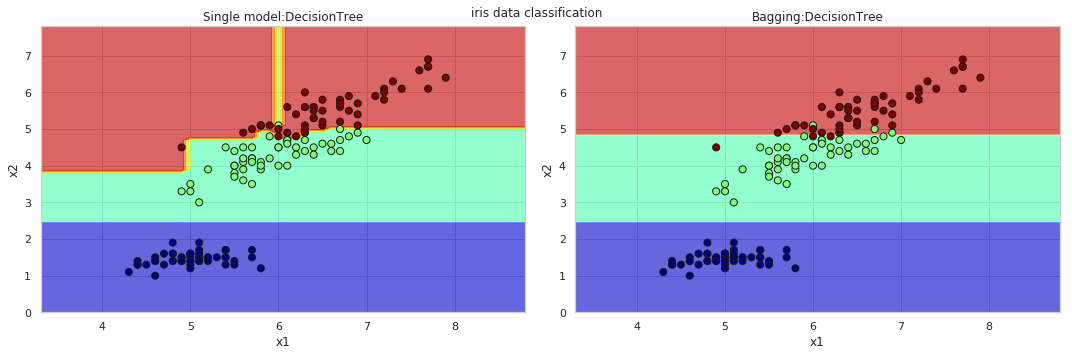

In [213]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier

iris = load_iris()
X, y = iris.data[:, [0, 2]], iris.target

mod1 = DecisionTreeClassifier(max_depth=10, random_state=99).fit(X, y)
mod2 = BaggingClassifier(DecisionTreeClassifier(max_depth=2), n_estimators=200,\
                        random_state=99).fit(X, y)

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

plt.figure(figsize=(15,5))
plt.subplot(121)
Z1 = mod1.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.contourf(xx, yy, Z1, alpha=0.6, cmap=mpl.cm.jet)
plt.scatter(X[:, 0], X[:, 1 ], c=y, alpha=1, s=50, cmap=mpl.cm.jet, edgecolors="k")
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Single model:DecisionTree')

plt.subplot(122)
Z2 = mod2.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.contourf(xx, yy, Z2, alpha=0.6, cmap=mpl.cm.jet)
plt.scatter(X[:, 0], X[:, 1 ], c=y, alpha=1, s=50, cmap=mpl.cm.jet, edgecolors="k")
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Bagging:DecisionTree')

plt.suptitle("iris data classification")
plt.tight_layout()
plt.show()

## 1.3 취합 - 랜덤 포레스트
- 개별모형: Decision Tree
- 데이터 일부 선택
- 노드 분리시 선택 가능한 독립변수 제한
- feature importance 계산 가능
    - information gain
- code
    - `RandomForestClassifier`
    - `ExtraTreesClassifier`

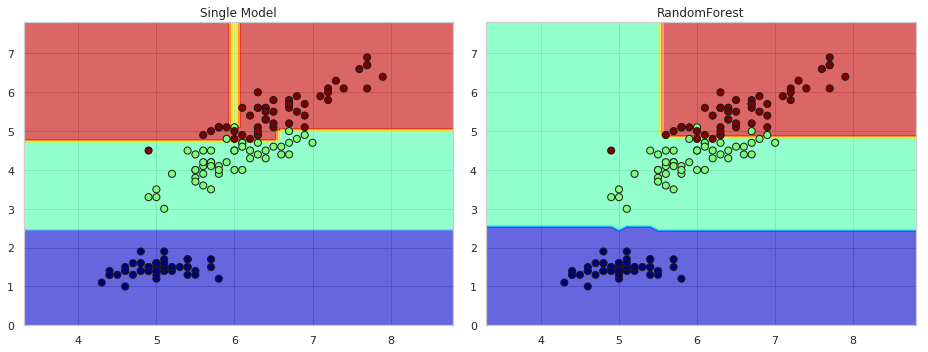

In [252]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

iris = load_iris()
X, y = iris.data[:, [0,2]], iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=99)

mod1 = DecisionTreeClassifier(max_depth=50, random_state=99).fit(X_train, y_train)
mod2 = RandomForestClassifier(max_depth=3, n_estimators=100, random_state=98).fit(X_train, y_train)

x_min, x_max = X[:, 0].min() -1, X[:, 0].max() +1
y_min, y_max = X[:, 1].min() -1, X[:, 1].max() +1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

plt.figure(figsize=(13,5))

plt.subplot(121)
Z1 = mod1.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.contourf(xx, yy, Z1, alpha=0.6, cmap=mpl.cm.jet)
plt.scatter(X[:, 0], X[:, 1], c=y, alpha=1, s=50, cmap=mpl.cm.jet, edgecolors='k')
plt.title('Single Model')

plt.subplot(122)
Z2 = mod2.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.contourf(xx, yy, Z2, alpha=0.6, cmap=mpl.cm.jet)
plt.scatter(X[:, 0], X[:, 1], c=y, alpha=1, s=50, cmap=mpl.cm.jet, edgecolors='k')
plt.title('RandomForest')

plt.tight_layout()
plt.show()

In [257]:
print("Decision Tree")
print(confusion_matrix(y_test, mod1.predict(X_test)))
print("RandomForest")
print(confusion_matrix(y_test, mod2.predict(X_test)))

Decision Tree
[[12  0  0]
 [ 0 16  2]
 [ 0  1 14]]
RandomForest
[[12  0  0]
 [ 0 17  1]
 [ 0  2 13]]


### feature importance

In [272]:
std[indices]

array([0.11687443, 0.05171959, 0.05619747, 0.03720789, 0.04004772,
       0.02735641, 0.0234166 , 0.00900153, 0.00919801, 0.00895686])

In [270]:
indices

array([7, 3, 0, 5, 6, 9, 8, 4, 1, 2])

In [268]:
importances

array([0.12500462, 0.03076822, 0.02965522, 0.12813838, 0.0308468 ,
       0.12022898, 0.11391683, 0.26327545, 0.07451564, 0.08364986])

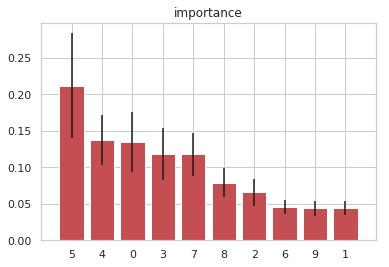

In [273]:
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier

X, y = make_classification(n_samples=1000, n_features=10,\
                          n_informative=5, n_classes=2)
forest = ExtraTreesClassifier(n_estimators=250, random_state=0)
forest.fit(X, y)

importances = forest.feature_importances_

std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

plt.title("importance")
plt.bar(range(X.shape[1]), importances[indices], color='r', yerr=std[indices], align='center')
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()